# Assignment 4
* In this assignment, we will train a simple U-net with Brats 2015 brain tumor dataset.
* Dice similarity coefficient is regarded as evaluation metric.

# Environment
* Use the following lines to import any needed libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import random as r
import math
import cv2
import glob
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, concatenate, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Utilities

In [3]:
def create_data(src, mask, label=False):
    
    """Load Brats data and save as numpy array.
    
    Parameters: 
        src(string): Specify source folder
        mask(string): Specify mask of filename 
        label(bool): Determine reading image or mask
    """
    
    files = glob.glob(src + mask, recursive=True)
    
    imgs = []
    
    print('Processing---', mask)
    for file in files:
        img = io.imread(file, plugin='simpleitk')
        if label:
            if label_num == 5:
                img[img != 0] = 1       # Region 1 => 1+2+3+4 complete tumor
            if label_num == 1:
                img[img != 1] = 0       # Only left necrosis
            if label_num == 2:
                img[img == 2] = 0       # Turn edema to 0
                img[img != 0] = 1       # Only keep necrosis, ET, NET = Tumor core
            if label_num == 4:
                img[img != 4] = 0       # Only left ET
                img[img == 4] = 1
            img = np.asarray(img, dtype = np.int32)
            for s in img:
                imgs.append(s)
        else:
            img = ((img-np.min(img)) / np.max(img)) * 2 - 1
            img = np.asarray(img, dtype = np.float32)
            for s in img:
                imgs.append(s)
    if label:            
        name = './data/sample_{}_mask'.format(pul_seq)
    else: 
        name = './data/sample_{}_image'.format(pul_seq)
    np.save(name, np.array(imgs).astype('float32'))  # Save at home
    print('Saved', len(files), 'subjects to', name)

In [4]:
def show_image(array, array2, random = False):
    
    """Show 2-D slices containing images and masks from 3-D array 

    Parameters:
        array(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W]
        array2(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W]
        random(bool): Flag determines show image following by index sequence or not.

    """
    
    n = 5
    if random == True:
        indices = np.random.randint(len(array), size=n)
        print('Show Random {} images and masks'.format(n))
    else:
        indices = np.arange(n)
        print('Show First {} images and masks'.format(n))
    images = array[indices, :]
    masks = array2[indices, :]
    fig, axes = plt.subplots(2, 5, figsize=(15,5))
    for i in range(5):
        image = images[i, :, :]
        mask = masks[i, :, :]
        axes[0, i].set_title("Image Index = {}".format(indices[i]))
        axes[0, i].axis("off")
        axes[0, i].imshow(image.reshape(images.shape[1], images.shape[2]), cmap='gray')
        axes[1, i].set_title("Mask Index = {}".format(indices[i]))
        axes[1, i].axis("off")
        axes[1, i].imshow(mask.reshape(masks.shape[1], masks.shape[2]), cmap='gray')
    plt.show()

# Data preparation
* Brats 2015 provide multi-modal MRI images inlcuding 4 types of pulse sequences
    * T1-weighted (T1)
    * T1-weighted with contrast enhancement (T1ce) 
    * T2-weighted (T2)
    * T2-weighted with fluid attenuated inversion recovery (T2-Flair)
* Brats 2015 is consisted of 220 high grade gliomas (HGG) and 54 low grade gliomas (LGG) MRIs scans from different patients.
    * Ground truth of 4 sub-regions available
        * Edema
        * Enhancing tumor
        * Non-enhancing tumor
        * Necrosis
* The task aims at segmenting full tumor lesions which are union of 4 types of labels mentioned above in HGG using T2-Flair data only.
* Each subject's original data is in the shape of [155, 240, 240] and normalized to range [-1 1] 
* Load and save the dataset by the given function
* Subplot a figure using a single subject's three dimensional data including images below
    * Axial view from middle slice
    * Sagital view from middle slice
    * Coronal view from middle slice
* Splitting dataset into training and testing set by your implemented function
    * Print the shape and display the images with masks by given function

In [5]:
def split_dataset(images, masks, image_size, seed=0, split=0.8):
    
    """Split data into training and testing sets using each subject's 50~90th axial slices data

    Parameters:
        images(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W]
        masks(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W]
        image_size(int): Resize image width and height with img_size
        seed(int): Specify fixed seed number
        split(float): Proportion of the dataset to include in the training set
        
    Returns:
        x_train(np.ndarray[int, int, int]): Training set of images, shape [N, H, W]
        y_train(np.ndarray[int, int, int]): Training set of masks, shape [N, H, W]
        x_test(np.ndarray[int, int, int]): Testing set of images, shape [N, H, W]
        y_test(np.ndarray[int, int, int]): Testing set of masks, shape [N, H, W]
    """
    
    
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    index = 0
    indices = np.arange(220)
    np.random.seed(seed)
    np.random.shuffle(indices)
    train_indices = indices[0:int(split*220)]
    test_indices = indices[int(split*220):]
    
    for indice in train_indices:
        imgs = images[indice*155+50:indice*155+90] # Slice 50~90
        ms = masks[indice*155+50:indice*155+90]
        for s, m in zip(imgs, ms):
            s = cv2.resize(s, (image_size, image_size), interpolation = cv2.INTER_LINEAR)
            m = cv2.resize(m, (image_size, image_size), interpolation = cv2.INTER_NEAREST)
            x_train.append(s)
            y_train.append(m)
    
    for indice in test_indices:
        imgs = images[indice*155+50:indice*155+90] # Slice 50~90
        ms = masks[indice*155+50:indice*155+90]
        for s, m in zip(imgs, ms):
            s = cv2.resize(s, (image_size, image_size), interpolation = cv2.INTER_LINEAR)
            m = cv2.resize(m, (image_size, image_size), interpolation = cv2.INTER_NEAREST)
            x_test.append(s)
            y_test.append(m)
    
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [6]:
pul_seq = 'Flair'
label_num = 5   # 1 = Necrosis, 2 = Tumor core, 4 = Enhancing Tumor, 5 = Whole Tumor

# create_data('./BRATS2015_Training/HGG/', '**/*{}*.mha'.format(pul_seq), label=False)
# create_data('./BRATS2015_Training/HGG/', '**/*OT*.mha', label=True)

In [7]:
imgs = np.load('./data/sample_{}_image.npy'.format(pul_seq))
masks = np.load('./data/sample_{}_mask.npy'.format(pul_seq))

In [8]:
def plot_view(imgs, masks, random = False):
    indice = 0
    if random == True:
        indice = np.random.randint(220)
    print('Show subject {}'.format(indice))
    selected_subject_img = imgs[indice*155:indice*155+155, :]
    selected_subject_mask = masks[indice*155:indice*155+155, :]
    fig, axes = plt.subplots(1, 3, figsize=(10,5))

    axes[0].set_title("Axial view")
    axes[0].axis("off")
    axes[0].imshow(selected_subject_img[70,:,:], cmap='gray')
    axes[1].set_title("Sagital view")
    axes[1].axis("off")
    axes[1].imshow(selected_subject_img[:,:,120], cmap='gray')
    axes[1].invert_yaxis()
    axes[2].set_title("Coronal view")
    axes[2].axis("off")
    axes[2].imshow(selected_subject_img[:,120,:], cmap='gray')
    axes[2].invert_yaxis()

Show subject 107


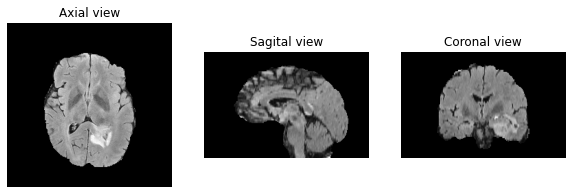

In [9]:
plot_view(imgs, masks, True)

In [10]:
seed = 0
split = 0.8
image_size = 192
x_train, y_train, x_test, y_test = split_dataset(imgs, masks, image_size=image_size, seed=seed, split=split)
print("Train shape:", str(x_train.shape), "\nTest shape:", str(x_test.shape))

Train shape: (7040, 192, 192) 
Test shape: (1760, 192, 192)


Train images and Masks
Show First 5 images and masks


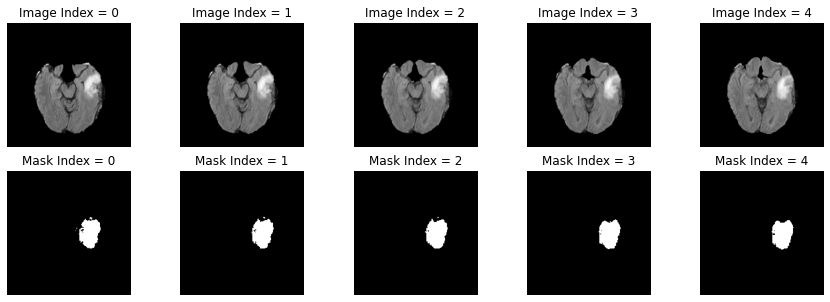

In [11]:
print("Train images and Masks")
show_image(x_train, y_train, False)

Test images and Masks
Show First 5 images and masks


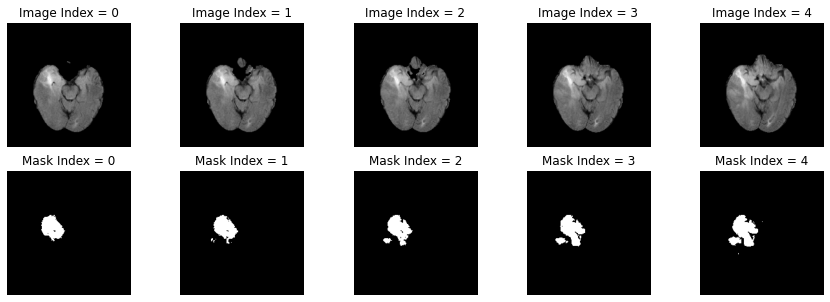

In [12]:
print("Test images and Masks")
show_image(x_test, y_test, False)

# Training
## Define the model 
* Display basic information about model containing total number of parameters
* Implement dice coefficient loss as loss function
* Save model architecture as .png or .jpg file under current directory

In [13]:
def dice_coef(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [14]:
def build_model(image_size=192):
    inputs = Input((image_size, image_size, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4= Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5= Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis = -1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6= Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(up6), conv3], axis = -1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7= Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    
    up8 = concatenate([UpSampling2D(size=(2, 2))(up7), conv2], axis = -1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8= Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    
    up9 = concatenate([UpSampling2D(size=(2, 2))(up8), conv1], axis = -1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9= Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    
    conv10= Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)    
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    model.summary()
    
    img_file = './model_arch.png'
    tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)
    
    return model

## Model fitting with dataset
* You may custumize the hyperparameters
* Add validation set to evaluate model performance during the training process
* Plot the history data of loss value in both training and validation set

In [15]:
num_epoch = 10
model = build_model(image_size)
history = model.fit(
        x_train, 
        y_train, 
        batch_size=16, 
        validation_split=0.2, 
        epochs = num_epoch, 
        verbose=1, 
        shuffle=True
)
model.save_weights('weights_imgsize{}_epoch{}_seed{}.h5'.format(image_size, num_epoch, seed))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 192, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 96, 96, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

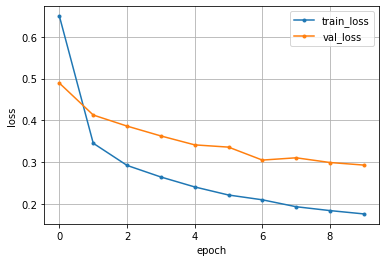

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(range(num_epoch), loss, marker='.', label='train_loss')
plt.plot(range(num_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# Evaluation
* Make prediction on testing set and display
* Calculate the average DC in testing set 

In [17]:
pred = model.predict(x_test, batch_size=1)

Prediction and Ground Truth
Show First 5 images and masks


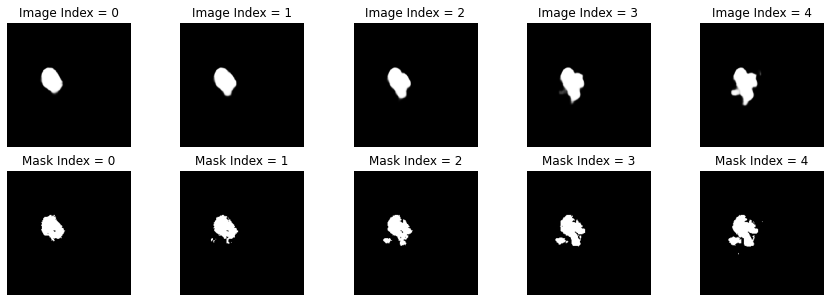

In [18]:
print('Prediction and Ground Truth')
show_image(pred, y_test, False)

In [19]:
print("Prediction DC = {:.2f}".format(dice_coef(y_test, pred)))

Prediction DC = 0.81
